In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
sent_df = pd.read_csv("Dataset-SA 2.csv")
max_count_product = sent_df["product_name"].value_counts().idxmax()


In [3]:
res_df = sent_df[sent_df["product_name"] == max_count_product]
res_df.describe()
res_df["Sentiment"].value_counts()

Sentiment
positive    5267
negative     602
neutral      136
Name: count, dtype: int64

In [4]:
res_df= res_df.drop_duplicates(subset=["Rate","Review","Summary"],keep="first")
res_df.describe()
res_df["Sentiment"].value_counts()


Sentiment
positive    3657
negative     585
neutral      116
Name: count, dtype: int64

In [5]:
res_df_sample =  res_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(frac=0.23, random_state=42))
res_df_sample.describe()

/tmp/ipykernel_54999/1437993029.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_df_sample =  res_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(frac=0.23, random_state=42))


,product_name,product_price,Rate,Review,Summary,Sentiment
count,1003,1003,1003,1003,1003,1003
unique,1,1,5,57,843,3
top,cello Pack of 18 Opalware Cello Dazzle Lush Fi...,1299,5,wonderful,good product,positive
freq,1003,1003,612,51,12,841


In [15]:
df = res_df_sample.drop(columns=["product_name","product_price"])
df

,Rate,Review,Summary,Sentiment
203085,2,moderate,small productvery bad,negative
203536,3,good,this set is really good but i got a defective ...,negative
200169,1,utterly disappointed,dont waste your moneyit breaks easilynot micro...,negative
204004,4,good quality product,small size,negative
204443,3,does the job,so small dinner set,negative
...,...,...,...,...
202858,5,classy product,thank u so much flipkart super quality must bu...,positive
201862,4,very good,i like super,positive
201662,5,best in the market!,at this price best in class,positive
199850,5,mind-blowing purchase,wonderful,positive


In [7]:
df["context"] = df["Review"] +" "+ df["Summary"]
# Encode the target variable 'Sentiment'
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['Sentiment'])

# Split data into features and target
X = df[['Rate', 'context']]
y = df['sentiment_encoded']

In [8]:
# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(X['context']).toarray()

# Combine with 'Rate' feature
X_rate = X['Rate'].values.reshape(-1, 1)
X_combined = np.hstack((X_rate, X_text))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


/tmp/ipykernel_54999/3598588797.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=res_df, x="Sentiment", palette="coolwarm")


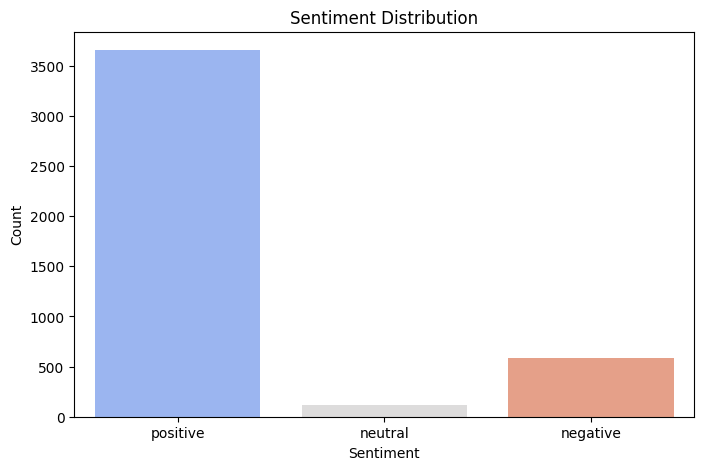

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(data=res_df, x="Sentiment", palette="coolwarm")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

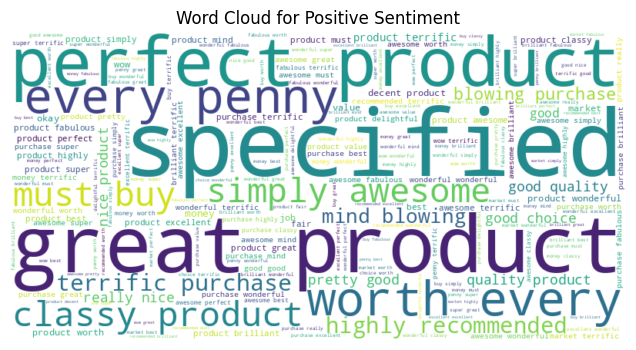

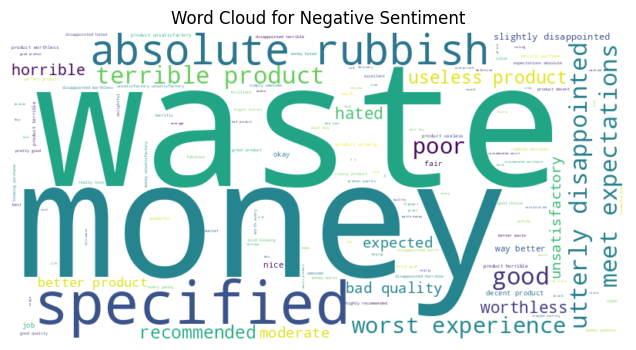

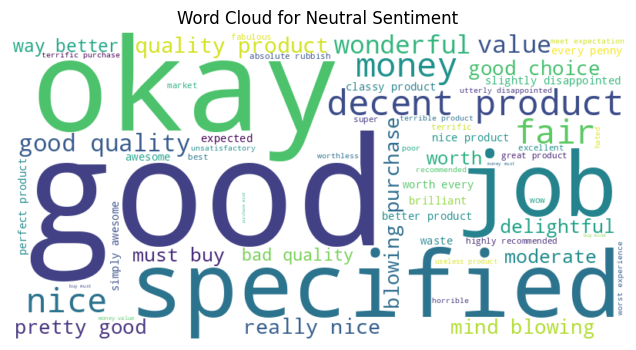

In [11]:
for sentiment in sent_df["Sentiment"].unique():
    text = " ".join(sent_df[sent_df["Sentiment"] == sentiment]["Review"].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.show()

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       0.50      0.50      0.50         4
           2       0.95      0.97      0.96       174

    accuracy                           0.93       201
   macro avg       0.75      0.72      0.74       201
weighted avg       0.93      0.93      0.93       201



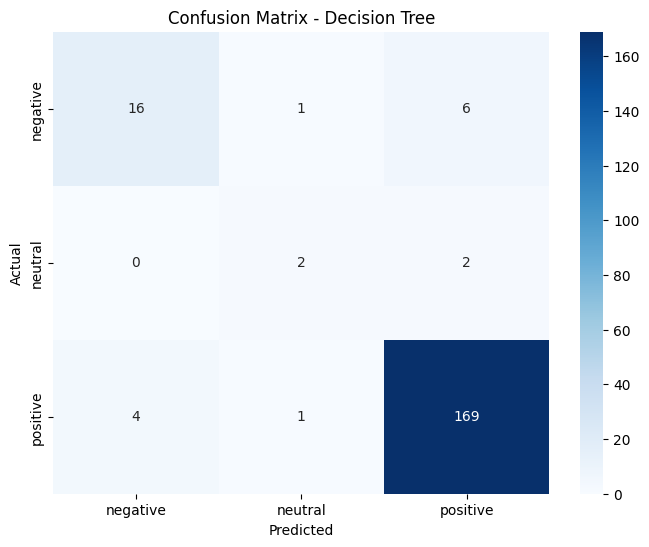

In [12]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
class_names = le.classes_
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.00      0.00      0.00         4
           2       0.97      0.99      0.98       174

    accuracy                           0.95       201
   macro avg       0.60      0.60      0.60       201
weighted avg       0.93      0.95      0.94       201

[[ 19   0   4]
 [  2   0   2]
 [  2   0 172]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


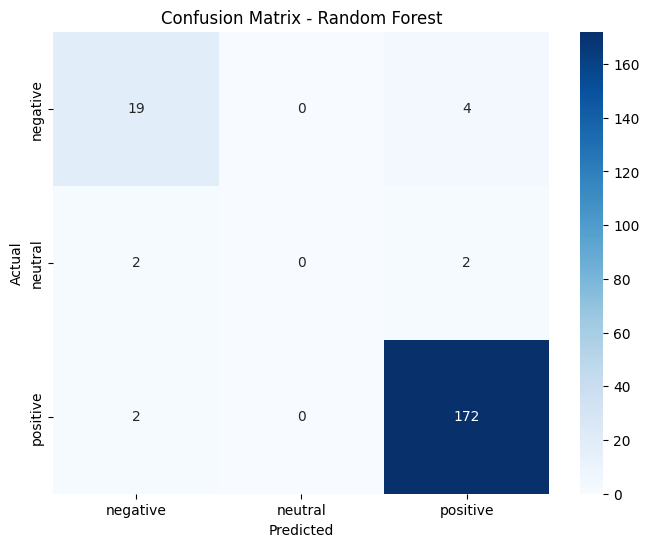

In [13]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Adjusted Rand Score: 0.34


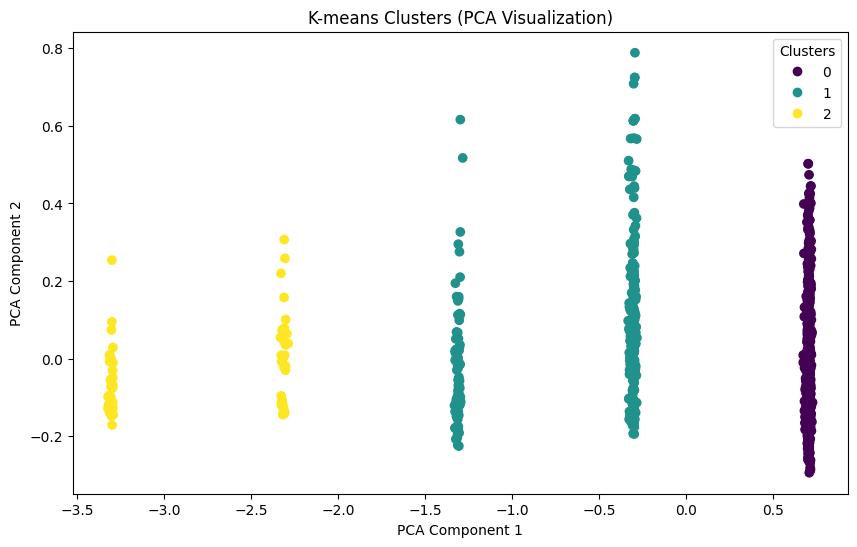

In [14]:

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_combined)

# Evaluate using Adjusted Rand Score (compares clusters with true labels)
ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Score: {ari:.2f}")

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-means Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()